**Описание задачи**

Сервис музыкального стримингового сервиса расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. 
На входе получены 3  датасета, в одном собраны некоторые характеристики музыкальных произведений и их жанры, во втором- такие же характеристики, но без целеого признака, и третий- для примера правильности выгрузки прогнозов. 

Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

 Этапы исследования:
* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.


Описание полей данных

**instance_id** -Уникальный идентификатор трека  
**track_name** - Название трека  
**acousticness** - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим. 1,0 означает высокую степень уверенности в том, что трек является акустическим.  
**danceability** - Танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность. Значение 0,0 означает наименьшую танцевальность, а 1,0 - наибольшую танцевальность.  
**duration_ms** - Продолжительность трека в миллисекундах.  
**energy** - Энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности. Как правило, энергичные композиции ощущаются как быстрые, громкие и шумные. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха имеет низкую оценку этого параметра  
**instrumentalness** - Определяет, содержит ли трек вокал. Звуки "Ooh" и "aah" в данном контексте рассматриваются как инструментальные. Рэп или разговорные треки явно являются "вокальными". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокала  
**key** - базовый ключ (нота) произведения  
**liveness** - Определяет присутствие аудитории в записи. Более высокие значения liveness означают увеличение вероятности того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек исполняется вживую  
**loudness** - Общая громкость трека в децибелах (дБ)  
**mode** - Указывает на модальность (мажорную или минорную) трека  
**speechiness** - Речевой характер определяет наличие в треке разговорной речи. Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0. Значения выше 0,66 характеризуют треки, которые, вероятно, полностью состоят из разговорной речи. Значения от 0,33 до 0,66 характеризуют треки, которые могут содержать как музыку, так и речь, как в виде фрагментов, так и в виде слоев, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие неречевые треки.  
**tempo** - Темп трека в ударах в минуту (BPM). В музыкальной терминологии темп представляет собой скорость или темп данного произведения и напрямую зависит от средней продолжительности тактов  
**obtained_date** - дата загрузки в сервис  
**valence** - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком. Композиции с высокой валентностью звучат более позитивно (например, радостно, весело, эйфорично), а композиции с низкой валентностью - более негативно (например, грустно, депрессивно, сердито)  

Целевой признак:

**music_genre** - Музыкальный жанр трека

**1. Импорт библиотек и предварительный просмотр данных**

In [19]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from math import log, cos, tan

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import f1_score

import phik
from phik.report import plot_correlation_matrix
from phik import report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 111

/kaggle/input/datasets-music/kaggle_music_genre_test.csv
/kaggle/input/datasets-music/sample_submit.csv
/kaggle/input/datasets-music/kaggle_music_genre_train.csv


In [20]:
df = pd.read_csv('/kaggle/input/datasets-music/kaggle_music_genre_train.csv')
test = pd.read_csv('/kaggle/input/datasets-music/kaggle_music_genre_test.csv')

In [21]:
df.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [22]:
df.shape

(20394, 16)

In [23]:
test.shape

(5099, 15)

In [24]:
test.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


Данные выгрузились корректно, начнем изучение

In [25]:
df.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


В признаках есть и пропуски и некорректные значения в некоторых данных (например duration отрицательный). Посмотрим, что можно будет с ними сделать 

In [28]:
df[df.duplicated()] # явных дубликатов нет

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre


In [29]:
df.isna().sum().sort_values(ascending=False)

key                 735
mode                506
tempo               442
instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
liveness              0
loudness              0
speechiness           0
obtained_date         0
valence               0
music_genre           0
dtype: int64

Но есть пропуски в столбцах key, mode и tempo, посмотрим на них

**2. Предобработка и исследовательский анализ данных**

In [30]:
df[df['key'].isna()]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
26,87453.0,"Serenade in B flat, K.361 ""Gran partita"": 3. A...",0.9910,0.154,-1.0,0.0384,0.902000,NaN,0.1090,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
49,87796.0,Star67,0.7470,0.478,294973.0,0.3950,0.000005,NaN,0.2640,-7.917,Major,0.2130,74.515,3-Apr,0.1700,Hip-Hop
60,69398.0,Sleep On The Floor,0.2490,0.389,211851.0,0.4310,0.000000,NaN,0.1300,-8.061,Major,0.0344,142.140,4-Apr,0.2750,Rock
75,20134.0,Rogue,0.0145,0.580,201694.0,0.7200,0.598000,NaN,0.2810,-5.541,Major,0.0638,143.816,4-Apr,0.1600,Electronic
107,69505.0,Party Song,0.1560,0.563,191760.0,0.8970,0.000000,NaN,0.3520,-4.996,Major,0.2130,157.803,4-Apr,0.7790,Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20312,50054.0,Dance with Me,0.5510,0.565,180480.0,0.3920,0.000106,NaN,0.2470,-10.083,Major,0.0268,98.485,4-Apr,0.4930,Country
20359,24889.0,Ho's,0.0560,0.850,207693.0,0.4360,0.000019,NaN,0.2960,-9.080,Major,0.0510,87.711,4-Apr,0.7700,Rock
20361,62172.0,"Bokurano Eien - Nando Umarekawattemo,Te Wo Tsu...",0.2710,0.581,324667.0,0.7920,0.000000,NaN,0.0993,-2.885,Major,0.0249,127.915,4-Apr,0.5700,Anime
20377,85249.0,Dreaming of Fiji,0.9750,0.162,114827.0,0.0395,0.979000,NaN,0.1050,-29.746,Minor,0.0427,109.043,4-Apr,0.0378,Classical


In [31]:
df[df['mode'].isna()]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
96,63867.0,"Clarinet Concerto No. 1 in F Minor, Op. 73, J....",0.973000,0.416,401000.0,0.0735,0.710000,F,0.0781,-20.723,NaN,0.0411,112.006,4-Apr,0.2220,Classical
129,75913.0,"Concerto for Viola d'amore, Lute, Strings and ...",0.926000,0.495,-1.0,0.1110,0.120000,C#,0.0772,-18.591,NaN,0.0506,78.772,4-Apr,0.4360,Classical
131,64391.0,She Keeps The Home Fires Burning,0.526000,0.731,236173.0,0.6080,0.000000,G,0.1260,-10.690,NaN,0.0267,126.263,4-Apr,0.7450,Country
292,37649.0,Ven - Continuous Mix,0.000216,0.555,50472.0,0.9530,0.059400,E,0.8180,-4.411,NaN,0.1090,114.885,4-Apr,0.3030,Electronic
326,43825.0,Wicked As It Seems,0.287000,0.689,285263.0,0.6200,0.000002,G,0.0368,-10.601,NaN,0.0339,110.860,4-Apr,0.9620,Blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20265,65040.0,Indestructible,0.041500,0.674,226413.0,0.6110,0.000001,D,0.0726,-6.322,NaN,0.0363,175.929,4-Apr,0.7820,Rock
20272,85638.0,I'm Waiting For The Man - Album Version (Stereo),0.029700,0.675,279520.0,0.6410,0.863000,G,0.1440,-9.754,NaN,0.0427,125.891,4-Apr,0.8540,Rock
20294,32079.0,Day Sixteen: Loser,0.006170,0.479,286373.0,0.7300,0.000007,B,0.5630,-9.424,NaN,0.0352,94.501,4-Apr,0.2440,Classical
20304,79390.0,Dancing Reflections,0.941000,0.203,334237.0,0.0778,0.702000,NaN,0.1630,-18.531,NaN,0.0335,91.704,3-Apr,0.0564,Anime


In [32]:
df[df['tempo'].isna()]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
63,45966.0,Back Door Man,0.287000,0.476,212427.0,0.612,0.000252,A,0.0877,-7.010,Major,0.0335,NaN,4-Apr,0.909,Rock
85,90217.0,familia,0.000059,0.489,269000.0,0.947,0.000000,C#,0.1130,-3.925,Minor,0.0419,NaN,4-Apr,0.517,Anime
114,79170.0,Poor Johnny,0.348000,0.698,362267.0,0.800,0.000087,B,0.4430,-3.091,Minor,0.0284,NaN,4-Apr,0.654,Blues
138,39716.0,Set Free (feat. Yael),0.008340,0.776,191210.0,0.783,0.044900,C,0.0377,-3.595,Major,0.0374,NaN,4-Apr,0.943,Electronic
145,48590.0,Running Away,0.001100,0.608,178440.0,0.801,0.000008,A,0.2230,-5.452,Minor,0.0376,NaN,3-Apr,0.544,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19929,57285.0,Letting You Go,0.008770,0.459,223655.0,0.903,0.000000,F,0.1680,-4.649,Minor,0.0673,NaN,4-Apr,0.364,Alternative
19988,72399.0,My Prerogative,0.065500,0.762,291560.0,0.625,0.000000,A,0.2520,-10.481,Major,0.0562,NaN,4-Apr,0.696,Rap
20138,31698.0,Angelina,0.508000,0.637,-1.0,0.486,0.000065,A,0.1770,-11.681,Major,0.0695,NaN,4-Apr,0.860,Blues
20212,54647.0,Chaos and Clothes,0.784000,0.560,214945.0,0.204,0.000000,F,0.1090,-15.395,Major,0.0448,NaN,4-Apr,0.282,Alternative


Как вариант заполнить пропуски медианой или средним, посомтрю, что лучше подходит

<Axes: >

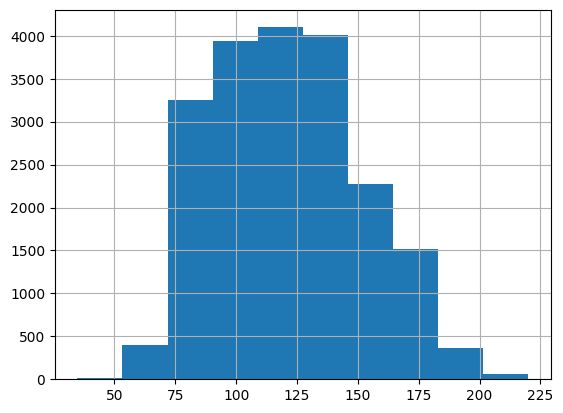

In [36]:
df['tempo'].hist()

In [34]:
df['tempo'].mean()

120.94252240376905

In [35]:
df['tempo'].median()

120.0125

Среднее и медиана примерно равны. Но пропуски я заполню медианой, так как при дальнейшем обучении моделей заполение медианой снизило метрику

In [38]:
df['tempo'].fillna(df['tempo'].mean(), inplace=True)
test['tempo'].fillna(test['tempo'].mean(), inplace=True)

In [39]:
df['tempo'].isna().sum()

0

Просмотрю все столбцы поочередно на предмет дубликатов/ошибок/опечаток в данных

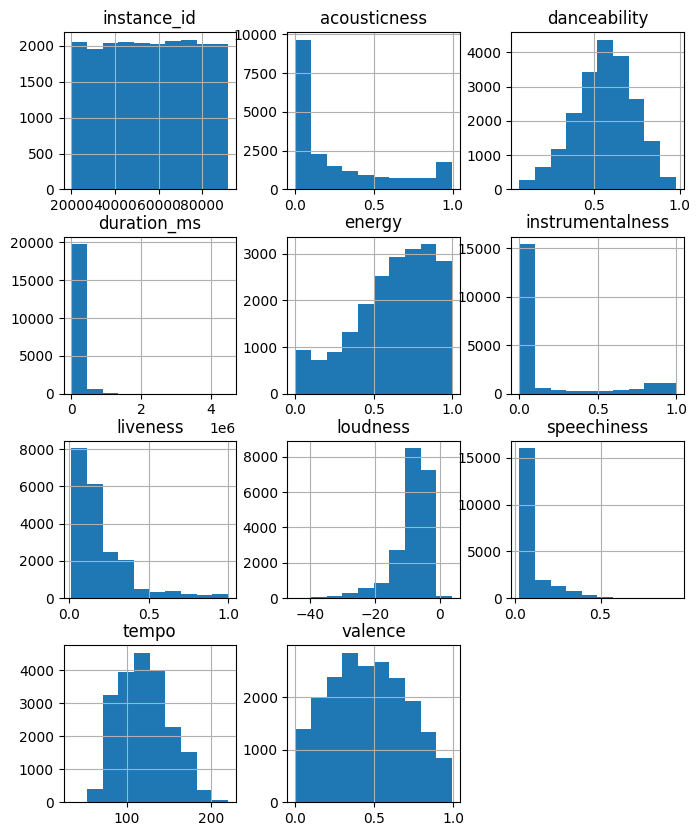

In [40]:
df.hist(figsize=(8,10));

Общие выводы по данным: 

acousticness - Не акустических треков большинство

danceability - Тут данные распределены нормально- танцевальность треков в основном средняя

duration_ms - Наблюдаю пик около нуля- надо изучить эту фичу подробнее

energy - Треки в основом энергичные

instrumentalness - Практически везде присутвует вокал

liveness - Треки в основном записаны в студии

loudness - Почти все треки с отрицательными децибеллами- такого быть не может, думаю нужно взять модуль

speechiness - Речи в треках  немного

tempo - средний темп около 100-150

valence - Также данные распределены ближе к нормальному

In [ ]:
df.head()

In [ ]:
df[df['duration_ms'] <= 10000].count() # проверим сколько треков длительностью меньше, чем 10 секунд

In [ ]:
df[df['duration_ms'] <= 10000].head(5)

In [ ]:
test[test['duration_ms'] <= 10000].head(5)

 Таких треков около 10 % - достаточно много. При беглом просмотре остальных фичей видим, что данные не пустые. Как вариант заполнить значения медианными или средними

In [ ]:
display(df['duration_ms'].median())
display(df['duration_ms'].mean())

Разница небольшая между медианой и средним

При заполнении значений в duration метрика снизилась. Для более глубокого исследования стоит попробовать заполить значения в зависимости от категории

In [ ]:
df['loudness'].hist(figsize=(4,3))

In [ ]:
df['track_name'].value_counts().head(10) # есть одинаковые названия треков, на всякий случай можно выборочно посмотреть

In [ ]:
df[df['track_name'] == 'Dreams']

Все данные разные, все в порядке

In [ ]:
df['key'].value_counts()

In [ ]:
df['mode'].value_counts()

Наблюдаем дисбаланс, можно попробовать сбалансировать 

In [ ]:
df['music_genre'].value_counts()

С ключом, модальностью (кроме дисбаланса) и жанрами проблем нет

In [ ]:
df['obtained_date'].value_counts()

4 Даты загрузки в сервис. Не информативный параметр, лучше от него избавиться. 

P.S. при обучении модели сохранение признака увеличило метрику

In [ ]:
df.duplicated().sum()

Явных дубликатов нет

Проверю наличие дубликатов по названию трека и, например, длительности

In [ ]:
df[df.duplicated(subset = ['track_name', 'duration_ms'], keep=False)].sort_values(by='track_name')

In [ ]:
df[df.duplicated(subset = ['track_name', 'duration_ms'], keep=False)].sort_values(by='track_name').count()

около 1150 дубликатов (около 5% данных)

Но лучше от них избавиться, так как при одинкановых значениях в признаках у них разные music_genre - это запутает модель


In [ ]:
df = df.drop_duplicates(subset = ['track_name', 'duration_ms'], keep=False)

In [ ]:
df.pivot_table(index='key', values=['duration_ms'])

In [ ]:
df['mode'].value_counts()

In [ ]:
df.head()

In [ ]:
df_num = df.drop(['track_name', 'key', 'mode', 'music_genre', 'obtained_date'], axis=1)

Посмотрим на корреляцию признаков

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(df_num.corr().round(2), annot=True);

In [ ]:
df_phik = df.phik_matrix()

plot_correlation_matrix(df_phik.values, x_labels=df_phik.columns, 
                        y_labels=df_phik.index, figsize=(10, 6))

Достаточно высокая корреляция между акустичностью и громкостью и громкостью и энергичностью. Возможно стоит обучать модель без параметра Громкости, много других признаков с ней коррелирует

**Вывод**:  

При предобработке данных были удалены неявные дубликаты (около 5% от общего количества данных)

Изначально хотел убрать признак obtained_date (из-за неиформативности) и loudness из-за высокой корреляции с другими признаками, но их удаление привело к снижению метрики модели

**3. Подготовка  данных к обучению**

In [ ]:
df.head()

Добавлю несколько синтетических признаков 

In [ ]:
df['len_track'] = df['track_name'].apply(len)
test['len_track'] = test['track_name'].apply(len)

In [ ]:
df['len_track'].sample(5)

In [ ]:
df['sin'] = df['danceability'].apply(log)
test['sin'] = test['danceability'].apply(log)

In [ ]:
df['sin']

In [ ]:
df['llog'] = df['energy'].apply(tan)
test['llog'] = test['energy'].apply(tan)

In [ ]:
df['track_name']

In [ ]:
df['track_name'].str.contains(r'ea').sum()

In [ ]:
df['som'] = df['track_name'].str.contains(r'ea') + 0
test['som'] = test['track_name'].str.contains(r'ea') + 0

In [ ]:
features = df.drop(['instance_id','track_name', 'music_genre'], axis=1)
target = df['music_genre']

Уберу из признаков ненужные параметры и назначу таргет

In [ ]:
features.head()

In [ ]:
cat_columns = features.select_dtypes(include='object').columns.tolist()
num_columns = features.select_dtypes(include=['float64','int64']).columns.tolist()

In [ ]:
cat_columns 

In [ ]:
num_columns

Сделаем сплит данных для дальнейшего обучения

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
features_train.head()

Выстроим пайплайн

In [ ]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [ ]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_columns),
    ('cat_pipeline',cat_pipeline,cat_columns)
    ],
    remainder='drop',
    n_jobs=-1)

**4. Выбор моделей и обучение**

Логистическая регрессия, дерево решений и случайный лес показали результаты хуже, чем catboost

Оставил их в ноутбуке без выполения кода

In [ ]:

iterat = 300
l_rate = 0.1

scaler = MinMaxScaler()
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
imputer_num = SimpleImputer(strategy='mean')
imouter_cat = SimpleImputer(strategy='most_frequent')

model = CatBoostClassifier(random_state=RANDOM_STATE, 
                         iterations=iterat, 
                         learning_rate=l_rate,
                         logging_level='Silent'

                        )

X_train_scaled  = scaler.fit_transform(features_train[num_columns])
X_test_scaled = scaler.transform(features_valid[num_columns])
test_scaled = scaler.transform(test[num_columns])

X_train_ohe = encoder.fit_transform(features_train[cat_columns])
X_test_ohe = encoder.transform(features_valid[cat_columns])
test_ohe = encoder.transform(test[cat_columns])

X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))
test_test = np.hstack((test_scaled, test_ohe))



In [ ]:
model.fit(X_train, target_train)
cat_preds = model.predict(X_test)
cat_score = f1_score(target_valid, cat_preds, average='micro')
print(f"Model score: {cat_score, iterat, l_rate}")

Model score: (0.4989613626921479, 300, 0.1)

Я провел обучение 4 моделей- одна линейная, две деревянные и один градиентный бустринг. ( LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier) получил следующие результаты:


 Данные в моделях обработал с помощью OHE, SimpleImputer и MinMaxScaler
Модель Logisticregression была обучена без подбора гиперпараметров. F1-мера - 0.42417


Модель DecisionTreeClassifier 
F1-мера - 0.41815 при 9 деревьях

Модель RandomForestClassifier 
 F1-мера - 0.4854



При обучении CatBoost я сначала использовал также OHE, SimpleImputer и MinMaxScaler, но в дальнейшем отказался от imputer, так как он ухудшал качество предсказаний
iterations =300, learning_rate=0.1 показали лучший результат в F1 0.4989

In [ ]:
test.head()

Сделаем предсказания на тестовой выборке

In [ ]:
cat_preds = model.predict(test_test)

In [ ]:
cat_preds

In [ ]:
file = pd.read_csv('/kaggle/input/datasets-music/sample_submit.csv')
file.head() # образец выгрузки

In [ ]:
test['music_genre'] = pd.DataFrame(cat_preds.tolist())

In [ ]:
predicts_genres = test[['instance_id', 'music_genre']]

In [ ]:
predicts_genres

In [ ]:
predicts_genres.to_csv('predicts_genres.csv', index=False) # выгрузим данные в csv

**ВЫВОД**

В процессе исследования проекта по классификации музыкальных произведений по жанрам для сервиса я выполнил следующие этапы работы: 
1. Импорт библиотек и предварительный просмотр данных
2. Предобработка и исследовательский анализ данных
3. Подготовка данных к обучению
4. Выбор моделей и обучение

Обучающий датасет содержал 20394 записей и 16 полей, а тестовый датасет - 5099 записей и 15 полей (без целевого признака)
Целевой признак для предсказания 'music_genre' 
Выявил проблемы, такие как наличие пропусков в некоторых полях (key, mode и tempo), дубликаты в данных.

Для предварительной обработки данных удалил ненужные поля, а именно track_name и obtained_at. Обработал пропуски и удалил дубликаты. Обнаружил дублирование данных (одинаковые категории и разные жанры) Таких данных было примерно 5% - удалил. Числовые пропуски в поле tempo заполнил средними значениями (медиана дала худший результат метрики)

Провел анализ корреляций. Добавил новые синтетические признаки, которые добавили точности к предсказанию модели

Для обучения моделей выбрал LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier. 
Подобрал гиперпараметры для CatBoost (мера F1 0.4989)

В конце проверил модель на тестовой выборке и подготовил файл для выгрузки на Kaggle. Результат на Kaggle в Privat - 0.51019

